## **State updates by nodes**

* In the previous notebook the state is being overwritten by the nodes which means we are losing all the updates
* If we want to preserve the previous data or make transformations on top of that data, we can use Anootations and reducer functions
* The following example shows three ways updates can be done. Either through messages, math operations or string operations
* As is shown in the example, state is not preserved between two seperate runs. Each run is isolated. The state updates are only applicable until the execution of the graph. After the execution, the state gets reset

In [1]:
from langgraph.graph import StateGraph, add_messages, START, END
from typing_extensions import TypedDict, Annotated
from operator import add

In [2]:
class State(TypedDict):
    var1: Annotated[list[str], add_messages]
    var2: Annotated[int, add]
    var3: Annotated[str, add]

In [3]:
builder1 = StateGraph(State)

def node1(state: State):
    return {"var1": ["b"], "var2": 2, "var3": "b"}

def node2(state: State):
    return {"var1": ["c"], "var2": 3, "var3": "c"}

builder1.add_node(node1, "node1")
builder1.add_node(node2, "node2")

builder1.add_edge(START, "node1")
builder1.add_edge("node1", "node2")
builder1.add_edge("node2", END)

graph1 =  builder1.compile()
graph1.debug = True

In [4]:
print(graph1.get_graph().print_ascii())

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
  +-------+    
  | node1 |    
  +-------+    
      *        
      *        
      *        
  +-------+    
  | node2 |    
  +-------+    
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   
None


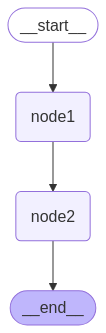

In [5]:
graph1

In [6]:
graph1.invoke({"var1": ["a"], "var2": 1, "var3": "a"})

[-1:checkpoint] State at the end of step -1:
{'var1': [], 'var2': 0, 'var3': ''}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'var1': ['a'], 'var2': 1, 'var3': 'a'}
[0:writes] Finished step 0 with writes to 3 channels:
- var1 -> ['a']
- var2 -> 1
- var3 -> 'a'
[0:checkpoint] State at the end of step 0:
{'var1': [HumanMessage(content='a', additional_kwargs={}, response_metadata={}, id='d494794b-815f-4799-9bff-d5e5bf8bfc89')],
 'var2': 1,
 'var3': 'a'}
[1:tasks] Starting 1 task for step 1:
- node1 -> {'var1': [HumanMessage(content='a', additional_kwargs={}, response_metadata={}, id='d494794b-815f-4799-9bff-d5e5bf8bfc89')],
 'var2': 1,
 'var3': 'a'}
[1:writes] Finished step 1 with writes to 3 channels:
- var1 -> ['b']
- var2 -> 2
- var3 -> 'b'
[1:checkpoint] State at the end of step 1:
{'var1': [HumanMessage(content='a', additional_kwargs={}, response_metadata={}, id='d494794b-815f-4799-9bff-d5e5bf8bfc89'),
          HumanMessage(content='b', additional_kwargs={}, response_metada

{'var1': [HumanMessage(content='a', additional_kwargs={}, response_metadata={}, id='d494794b-815f-4799-9bff-d5e5bf8bfc89'),
  HumanMessage(content='b', additional_kwargs={}, response_metadata={}, id='55402d94-05c0-4074-b32f-f44a07ecf143'),
  HumanMessage(content='c', additional_kwargs={}, response_metadata={}, id='8c58a48c-1169-459f-9a05-d2075630790c')],
 'var2': 6,
 'var3': 'abc'}

In [7]:
graph1.invoke({"var1": ["c"], "var2": 5, "var3": "c"})

[-1:checkpoint] State at the end of step -1:
{'var1': [], 'var2': 0, 'var3': ''}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'var1': ['c'], 'var2': 5, 'var3': 'c'}
[0:writes] Finished step 0 with writes to 3 channels:
- var1 -> ['c']
- var2 -> 5
- var3 -> 'c'
[0:checkpoint] State at the end of step 0:
{'var1': [HumanMessage(content='c', additional_kwargs={}, response_metadata={}, id='a90d8633-a41a-4aa7-a437-ee509a5b6415')],
 'var2': 5,
 'var3': 'c'}
[1:tasks] Starting 1 task for step 1:
- node1 -> {'var1': [HumanMessage(content='c', additional_kwargs={}, response_metadata={}, id='a90d8633-a41a-4aa7-a437-ee509a5b6415')],
 'var2': 5,
 'var3': 'c'}
[1:writes] Finished step 1 with writes to 3 channels:
- var1 -> ['b']
- var2 -> 2
- var3 -> 'b'
[1:checkpoint] State at the end of step 1:
{'var1': [HumanMessage(content='c', additional_kwargs={}, response_metadata={}, id='a90d8633-a41a-4aa7-a437-ee509a5b6415'),
          HumanMessage(content='b', additional_kwargs={}, response_metada

{'var1': [HumanMessage(content='c', additional_kwargs={}, response_metadata={}, id='a90d8633-a41a-4aa7-a437-ee509a5b6415'),
  HumanMessage(content='b', additional_kwargs={}, response_metadata={}, id='3ae163df-c8a3-4952-8923-71154fa6dae1'),
  HumanMessage(content='c', additional_kwargs={}, response_metadata={}, id='b5035ed7-7742-4e5b-a53b-b104aa516a60')],
 'var2': 10,
 'var3': 'cbc'}

## **Multiple Annotated states**

* Overall state uses add_messages as reducer and input and output states use add operator as reducer
* As provided, the add_messages reducer adds Human message objects to the list
* add operator simply extend the list with the new data
* We can even update multiple states as needed in a single node

In [8]:
from operator import add

class State1(TypedDict):
    vara: Annotated[list[str], add]

class State2(TypedDict):
    varb: Annotated[list[str], add]

In [9]:
builder2 = StateGraph(State, input = State1, output = State2)

def node1(state: State1) -> State2:
    data = "".join(state["vara"]) + "1"
    return {"varb": [data], "var1" : [data]}

def node2(state: State2) -> State2:
    data = "".join(state["varb"]) + "2"
    return {"varb": [data], "var1" : [data]}

def node3(state: State2) -> State1:
    data = "".join(state["varb"]) + "3"
    return {"vara": [data], "var1" : [data]}

builder2.add_node(node1, "node1")
builder2.add_node(node2, "node2")
builder2.add_node(node3, "node3")

builder2.add_edge(START, "node1")
builder2.add_edge("node1", "node2")
builder2.add_edge("node2", "node3")
builder2.add_edge("node3", END)

graph2 = builder2.compile()
graph2.debug = True

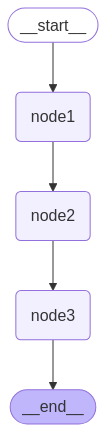

In [10]:
graph2

In [13]:
graph2.invoke({"vara": ["1"]})

[-1:checkpoint] State at the end of step -1:
{'var1': [], 'var2': 0, 'var3': '', 'vara': [], 'varb': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'vara': ['1']}
[0:writes] Finished step 0 with writes to 1 channel:
- vara -> ['1']
[0:checkpoint] State at the end of step 0:
{'var1': [], 'var2': 0, 'var3': '', 'vara': ['1'], 'varb': []}
[1:tasks] Starting 1 task for step 1:
- node1 -> {'vara': ['1']}
[1:writes] Finished step 1 with writes to 2 channels:
- varb -> ['11']
- var1 -> ['11']
[1:checkpoint] State at the end of step 1:
{'var1': [HumanMessage(content='11', additional_kwargs={}, response_metadata={}, id='0381af6a-edd3-4ca5-a5a7-02ac416a0471')],
 'var2': 0,
 'var3': '',
 'vara': ['1'],
 'varb': ['11']}
[2:tasks] Starting 1 task for step 2:
- node2 -> {'varb': ['11']}
[2:writes] Finished step 2 with writes to 2 channels:
- varb -> ['112']
- var1 -> ['112']
[2:checkpoint] State at the end of step 2:
{'var1': [HumanMessage(content='11', additional_kwargs={}, response_meta

{'varb': ['11', '112']}

In [12]:
graph2.invoke({"vara": ["0"]})

[-1:checkpoint] State at the end of step -1:
{'var1': [], 'var2': 0, 'var3': '', 'vara': [], 'varb': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'vara': ['0']}
[0:writes] Finished step 0 with writes to 1 channel:
- vara -> ['0']
[0:checkpoint] State at the end of step 0:
{'var1': [], 'var2': 0, 'var3': '', 'vara': ['0'], 'varb': []}
[1:tasks] Starting 1 task for step 1:
- node1 -> {'vara': ['0']}
[1:writes] Finished step 1 with writes to 2 channels:
- varb -> ['01']
- var1 -> ['01']
[1:checkpoint] State at the end of step 1:
{'var1': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='1d4316ba-fdd7-4612-a270-7671c43a1a5e')],
 'var2': 0,
 'var3': '',
 'vara': ['0'],
 'varb': ['01']}
[2:tasks] Starting 1 task for step 2:
- node2 -> {'varb': ['01']}
[2:writes] Finished step 2 with writes to 2 channels:
- varb -> ['012']
- var1 -> ['012']
[2:checkpoint] State at the end of step 2:
{'var1': [HumanMessage(content='01', additional_kwargs={}, response_meta

{'varb': ['01', '012']}

## **Persistent Memory for the graph**

* As we saw before, state is not being persisted between runs. So, we introduce memory to the graph
* To invoke the graph with memory initialized, it needs a config parameter. We can use this config to identify the state of the graph

In [14]:
from langgraph.checkpoint.memory import MemorySaver

In [15]:
checkpointer = MemorySaver()

graph3 = builder2.compile(checkpointer = checkpointer)
graph3.debug = True

In [16]:
graph3.invoke({"var1" : ["0"]})

ValueError: Checkpointer requires one or more of the following 'configurable' keys: ['thread_id', 'checkpoint_ns', 'checkpoint_id']

In [17]:
graph3.invoke({"var1" : ["0"]}, {"configurable" : {"thread_id" : "1"}})

[-1:checkpoint] State at the end of step -1:
{'var1': [], 'var2': 0, 'var3': '', 'vara': [], 'varb': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'var1': ['0']}
[0:writes] Finished step 0 with writes to 0 channels:

[0:checkpoint] State at the end of step 0:
{'var1': [], 'var2': 0, 'var3': '', 'vara': [], 'varb': []}
[1:tasks] Starting 1 task for step 1:
- node1 -> {'vara': []}
[1:writes] Finished step 1 with writes to 2 channels:
- varb -> ['1']
- var1 -> ['1']
[1:checkpoint] State at the end of step 1:
{'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='f243f493-96dc-4875-9ef3-6ce178d8ed0a')],
 'var2': 0,
 'var3': '',
 'vara': [],
 'varb': ['1']}
[2:tasks] Starting 1 task for step 2:
- node2 -> {'varb': ['1']}
[2:writes] Finished step 2 with writes to 2 channels:
- varb -> ['12']
- var1 -> ['12']
[2:checkpoint] State at the end of step 2:
{'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='f243f493-96dc-4875

{'varb': ['1', '12']}

In [18]:
graph3.get_state({"configurable" : {"thread_id" : "1"}})

StateSnapshot(values={'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='f243f493-96dc-4875-9ef3-6ce178d8ed0a'), HumanMessage(content='12', additional_kwargs={}, response_metadata={}, id='33b0126a-cb2c-487c-a376-7c5bc189efd8'), HumanMessage(content='1123', additional_kwargs={}, response_metadata={}, id='c32d2194-a103-492a-ba2a-88c5eff0c35a')], 'var2': 0, 'var3': '', 'vara': ['1123'], 'varb': ['1', '12']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0245c6-179b-613f-8003-ed1fe39ee952'}}, metadata={'source': 'loop', 'writes': {'node3': None}, 'step': 3, 'parents': {}, 'thread_id': '1'}, created_at='2025-04-28T18:12:43.944172+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0245c6-1793-6528-8002-6ea4a8444884'}}, tasks=())

In [20]:
list(graph3.get_state_history({"configurable" : {"thread_id" : "1"}}))

[StateSnapshot(values={'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='f243f493-96dc-4875-9ef3-6ce178d8ed0a'), HumanMessage(content='12', additional_kwargs={}, response_metadata={}, id='33b0126a-cb2c-487c-a376-7c5bc189efd8'), HumanMessage(content='1123', additional_kwargs={}, response_metadata={}, id='c32d2194-a103-492a-ba2a-88c5eff0c35a')], 'var2': 0, 'var3': '', 'vara': ['1123'], 'varb': ['1', '12']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0245c6-179b-613f-8003-ed1fe39ee952'}}, metadata={'source': 'loop', 'writes': {'node3': None}, 'step': 3, 'parents': {}, 'thread_id': '1'}, created_at='2025-04-28T18:12:43.944172+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0245c6-1793-6528-8002-6ea4a8444884'}}, tasks=()),
 StateSnapshot(values={'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='f243f493-96dc-4875-9ef3-6ce178d8

In [21]:
graph3.invoke({"var1" : ["1"]}, {"configurable" : {"thread_id" : "1"}})

[4:checkpoint] State at the end of step 4:
{'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='f243f493-96dc-4875-9ef3-6ce178d8ed0a'),
          HumanMessage(content='12', additional_kwargs={}, response_metadata={}, id='33b0126a-cb2c-487c-a376-7c5bc189efd8'),
          HumanMessage(content='1123', additional_kwargs={}, response_metadata={}, id='c32d2194-a103-492a-ba2a-88c5eff0c35a')],
 'var2': 0,
 'var3': '',
 'vara': ['1123'],
 'varb': ['1', '12']}
[5:tasks] Starting 1 task for step 5:
- __start__ -> {'var1': ['1']}
[5:writes] Finished step 5 with writes to 0 channels:

[5:checkpoint] State at the end of step 5:
{'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='f243f493-96dc-4875-9ef3-6ce178d8ed0a'),
          HumanMessage(content='12', additional_kwargs={}, response_metadata={}, id='33b0126a-cb2c-487c-a376-7c5bc189efd8'),
          HumanMessage(content='1123', additional_kwargs={}, response_metadata={}, id='c32d2194-a1

{'varb': ['1', '12', '11231', '112112312']}

In [23]:
state = graph3.get_state({"configurable" : {"thread_id" : "1"}})

In [24]:
state

StateSnapshot(values={'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='f243f493-96dc-4875-9ef3-6ce178d8ed0a'), HumanMessage(content='12', additional_kwargs={}, response_metadata={}, id='33b0126a-cb2c-487c-a376-7c5bc189efd8'), HumanMessage(content='1123', additional_kwargs={}, response_metadata={}, id='c32d2194-a103-492a-ba2a-88c5eff0c35a'), HumanMessage(content='11231', additional_kwargs={}, response_metadata={}, id='e3abffb0-6a20-40ac-a49d-e0e1283df993'), HumanMessage(content='112112312', additional_kwargs={}, response_metadata={}, id='93bef08a-cf28-4923-a310-2687cbc77cb4'), HumanMessage(content='112112311121123123', additional_kwargs={}, response_metadata={}, id='873ecc3c-587d-47c9-a8c6-0259e8e313a4')], 'var2': 0, 'var3': '', 'vara': ['1123', '112112311121123123'], 'varb': ['1', '12', '11231', '112112312']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0245cd-04c0-6a00-8008-f40bdeaea4ba'}}, metadata={'s

In [25]:
state.values

{'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='f243f493-96dc-4875-9ef3-6ce178d8ed0a'),
  HumanMessage(content='12', additional_kwargs={}, response_metadata={}, id='33b0126a-cb2c-487c-a376-7c5bc189efd8'),
  HumanMessage(content='1123', additional_kwargs={}, response_metadata={}, id='c32d2194-a103-492a-ba2a-88c5eff0c35a'),
  HumanMessage(content='11231', additional_kwargs={}, response_metadata={}, id='e3abffb0-6a20-40ac-a49d-e0e1283df993'),
  HumanMessage(content='112112312', additional_kwargs={}, response_metadata={}, id='93bef08a-cf28-4923-a310-2687cbc77cb4'),
  HumanMessage(content='112112311121123123', additional_kwargs={}, response_metadata={}, id='873ecc3c-587d-47c9-a8c6-0259e8e313a4')],
 'var2': 0,
 'var3': '',
 'vara': ['1123', '112112311121123123'],
 'varb': ['1', '12', '11231', '112112312']}

In [26]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0245cd-04c0-6a00-8008-f40bdeaea4ba'}}

In [27]:
state.metadata

{'source': 'loop',
 'writes': {'node3': None},
 'step': 8,
 'parents': {},
 'thread_id': '1'}

In [28]:
list(graph3.get_state_history({"configurable" : {"thread_id" : "1"}}))

[StateSnapshot(values={'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='f243f493-96dc-4875-9ef3-6ce178d8ed0a'), HumanMessage(content='12', additional_kwargs={}, response_metadata={}, id='33b0126a-cb2c-487c-a376-7c5bc189efd8'), HumanMessage(content='1123', additional_kwargs={}, response_metadata={}, id='c32d2194-a103-492a-ba2a-88c5eff0c35a'), HumanMessage(content='11231', additional_kwargs={}, response_metadata={}, id='e3abffb0-6a20-40ac-a49d-e0e1283df993'), HumanMessage(content='112112312', additional_kwargs={}, response_metadata={}, id='93bef08a-cf28-4923-a310-2687cbc77cb4'), HumanMessage(content='112112311121123123', additional_kwargs={}, response_metadata={}, id='873ecc3c-587d-47c9-a8c6-0259e8e313a4')], 'var2': 0, 'var3': '', 'vara': ['1123', '112112311121123123'], 'varb': ['1', '12', '11231', '112112312']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0245cd-04c0-6a00-8008-f40bdeaea4ba'}}, metadata={'

## **Memory Store for Graphs**

* Persistent memory or memory savers preserve states between runs. Stores preserve state between threads
* We can think of memory savers segregating chats through threads and store segregate chats through users
* So, we need thread_id for each run using memory saver and user_id for each run using store

In [30]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore

In [33]:
checkpointer = InMemorySaver()
store = InMemoryStore()

graph4 = builder2.compile(checkpointer = checkpointer, store = store)
graph4.debug = True

In [34]:
graph4.invoke({"var1" : ["0"]}, {"configurable" : {"thread_id" : "1", "user_id" : "1"}})

[-1:checkpoint] State at the end of step -1:
{'var1': [], 'var2': 0, 'var3': '', 'vara': [], 'varb': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'var1': ['0']}
[0:writes] Finished step 0 with writes to 0 channels:

[0:checkpoint] State at the end of step 0:
{'var1': [], 'var2': 0, 'var3': '', 'vara': [], 'varb': []}
[1:tasks] Starting 1 task for step 1:
- node1 -> {'vara': []}
[1:writes] Finished step 1 with writes to 2 channels:
- varb -> ['1']
- var1 -> ['1']
[1:checkpoint] State at the end of step 1:
{'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='a4348a6d-4f33-4ea5-84c3-e3d62c4b0888')],
 'var2': 0,
 'var3': '',
 'vara': [],
 'varb': ['1']}
[2:tasks] Starting 1 task for step 2:
- node2 -> {'varb': ['1']}
[2:writes] Finished step 2 with writes to 2 channels:
- varb -> ['12']
- var1 -> ['12']
[2:checkpoint] State at the end of step 2:
{'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='a4348a6d-4f33-4ea5

{'varb': ['1', '12']}

In [35]:
list(graph4.get_state_history({"configurable" : {"thread_id" : "1", "user_id" : "1"}}))

[StateSnapshot(values={'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='a4348a6d-4f33-4ea5-84c3-e3d62c4b0888'), HumanMessage(content='12', additional_kwargs={}, response_metadata={}, id='3ce1ed1c-2a9a-480e-99cf-8b84c84ebaec'), HumanMessage(content='1123', additional_kwargs={}, response_metadata={}, id='72f4de6f-761c-4e04-aa1f-8a107dd1880a')], 'var2': 0, 'var3': '', 'vara': ['1123'], 'varb': ['1', '12']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f024603-3398-69c6-8003-595e57a12089'}}, metadata={'source': 'loop', 'writes': {'node3': None}, 'step': 3, 'parents': {}, 'thread_id': '1', 'user_id': '1'}, created_at='2025-04-28T18:40:04.335456+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f024603-3391-6f2f-8002-e9cf8171baa0'}}, tasks=()),
 StateSnapshot(values={'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='a4348a6d-4f33-4e

In [36]:
graph4.invoke({"var1" : ["0"]}, {"configurable" : {"thread_id" : "1", "user_id" : "1"}})

[4:checkpoint] State at the end of step 4:
{'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='a4348a6d-4f33-4ea5-84c3-e3d62c4b0888'),
          HumanMessage(content='12', additional_kwargs={}, response_metadata={}, id='3ce1ed1c-2a9a-480e-99cf-8b84c84ebaec'),
          HumanMessage(content='1123', additional_kwargs={}, response_metadata={}, id='72f4de6f-761c-4e04-aa1f-8a107dd1880a')],
 'var2': 0,
 'var3': '',
 'vara': ['1123'],
 'varb': ['1', '12']}
[5:tasks] Starting 1 task for step 5:
- __start__ -> {'var1': ['0']}
[5:writes] Finished step 5 with writes to 0 channels:

[5:checkpoint] State at the end of step 5:
{'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='a4348a6d-4f33-4ea5-84c3-e3d62c4b0888'),
          HumanMessage(content='12', additional_kwargs={}, response_metadata={}, id='3ce1ed1c-2a9a-480e-99cf-8b84c84ebaec'),
          HumanMessage(content='1123', additional_kwargs={}, response_metadata={}, id='72f4de6f-76

{'varb': ['1', '12', '11231', '112112312']}

In [37]:
list(graph4.get_state_history({"configurable" : {"thread_id" : "1", "user_id" : "1"}}))

[StateSnapshot(values={'var1': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='a4348a6d-4f33-4ea5-84c3-e3d62c4b0888'), HumanMessage(content='12', additional_kwargs={}, response_metadata={}, id='3ce1ed1c-2a9a-480e-99cf-8b84c84ebaec'), HumanMessage(content='1123', additional_kwargs={}, response_metadata={}, id='72f4de6f-761c-4e04-aa1f-8a107dd1880a'), HumanMessage(content='11231', additional_kwargs={}, response_metadata={}, id='027d8fe1-d34e-48a2-837f-56a2cc280ff4'), HumanMessage(content='112112312', additional_kwargs={}, response_metadata={}, id='af3a6246-cd4d-4b4c-9960-ecff653b973a'), HumanMessage(content='112112311121123123', additional_kwargs={}, response_metadata={}, id='0862d64e-eec7-4093-9f71-980d9842f142')], 'var2': 0, 'var3': '', 'vara': ['1123', '112112311121123123'], 'varb': ['1', '12', '11231', '112112312']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f024605-66d0-6b96-8008-95b787e35fcb'}}, metadata={'

In [38]:
store.list_namespaces()

[]

## **Experimenting on store**

* As provided, the memory store takes in a namespace, key and value as parameters
* Namespace is a tuple with values which can be thought of as a table name and the user ID in a database
* The key is the ID for each record in the table and the value is the data for each record
* The store is basically a NoSQL key-value database containing a hierarchical key of user ID and table name
* It can contain as many users and as many tables for each users as needed
* Based on the logic of the flow, we can store required memory for each user through the configurable parameters
* As thread ID is not a field in the store, this store can be thought of as a memory across threads

In [40]:
memory_store = InMemoryStore()

In [41]:
memory_store.list_namespaces()

[]

In [42]:
table = "memories"
user_id = "1"

namespace = (table, user_id)

memory_id = "1"
data = {"Food" : "Dosa"}

memory_store.put(namespace = namespace, key = memory_id, value = data)

In [43]:
memory_store.search(namespace)

[Item(namespace=['memories', '1'], key='1', value={'Food': 'Dosa'}, created_at='2025-04-28T18:51:48.220833+00:00', updated_at='2025-04-28T18:51:48.220833+00:00', score=None)]

In [44]:
memory_store.put(namespace = namespace, key = "2", value = {"Drink" : "Water"})

In [45]:
memory_store.search(namespace)

[Item(namespace=['memories', '1'], key='1', value={'Food': 'Dosa'}, created_at='2025-04-28T18:51:48.220833+00:00', updated_at='2025-04-28T18:51:48.220833+00:00', score=None),
 Item(namespace=['memories', '1'], key='2', value={'Drink': 'Water'}, created_at='2025-04-28T18:53:17.759920+00:00', updated_at='2025-04-28T18:53:17.759920+00:00', score=None)]

In [46]:
memory_store.search(namespace)[-1].dict()

{'namespace': ['memories', '1'],
 'key': '2',
 'value': {'Drink': 'Water'},
 'created_at': '2025-04-28T18:53:17.759920+00:00',
 'updated_at': '2025-04-28T18:53:17.759920+00:00',
 'score': None}

In [47]:
memory_store.put(namespace = ("memories", "2"), key = "1", value = {"Food" : "Idly"})

In [48]:
memory_store.put(namespace = ("memories", "2"), key = "2", value = {"Drink" : "Water"})

In [51]:
memory_store.search(namespace)

[Item(namespace=['memories', '1'], key='1', value={'Food': 'Dosa'}, created_at='2025-04-28T18:51:48.220833+00:00', updated_at='2025-04-28T18:51:48.220833+00:00', score=None),
 Item(namespace=['memories', '1'], key='2', value={'Drink': 'Water'}, created_at='2025-04-28T18:53:17.759920+00:00', updated_at='2025-04-28T18:53:17.759920+00:00', score=None)]

In [52]:
memory_store.search(("memories", "2"))

[Item(namespace=['memories', '2'], key='1', value={'Food': 'Idly'}, created_at='2025-04-28T18:55:15.020403+00:00', updated_at='2025-04-28T18:55:15.020403+00:00', score=None),
 Item(namespace=['memories', '2'], key='2', value={'Drink': 'Water'}, created_at='2025-04-28T18:55:31.581105+00:00', updated_at='2025-04-28T18:55:31.581105+00:00', score=None)]

In [53]:
memory_store.list_namespaces()

[('memories', '1'), ('memories', '2')]

In [54]:
memory_store.put(namespace = ("docs", "1"), key = "1", value = {"name" : "1.pdf", "size" : 100})

In [55]:
memory_store.list_namespaces()

[('docs', '1'), ('memories', '1'), ('memories', '2')]

In [56]:
memory_store.search(("docs", "1"))

[Item(namespace=['docs', '1'], key='1', value={'name': '1.pdf', 'size': 100}, created_at='2025-04-28T18:58:11.220076+00:00', updated_at='2025-04-28T18:58:11.220076+00:00', score=None)]

In [57]:
memory_store.search(("docs", "2"))

[]

In [61]:
memory_store.get(namespace = ("memories", "1"), key = "2")

Item(namespace=['memories', '1'], key='2', value={'Drink': 'Water'}, created_at='2025-04-28T18:53:17.759920+00:00', updated_at='2025-04-28T18:53:17.759920+00:00')